In [93]:
# Import Libraries

import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset

import cv2
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

# from gradcam import GradCAM, GradCAMpp
# from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import dill
import torch.multiprocessing as mp

ModuleNotFoundError: No module named 'gradcam'

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Specify the path to the locally saved dataset
train_data_dir = '/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset'
train_dataset = datasets.ImageFolder(train_data_dir)

In [78]:
# Preprocessing steps used for imagenet dataset with the original AlexNet model
def apply_clahe(opencv_img):
    # Convert to LAB color space
    lab = cv2.cvtColor(opencv_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # Convert back to RGB color space
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final_img

def transform_opencv_to_pil(opencv_img):
    # Convert an OpenCV image to PIL image
    color_coverted = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(color_coverted)
    return pil_img

preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=200, threshold=3))),
    # transforms.Lambda(lambda img: transform_opencv_to_pil(apply_clahe(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)))),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor() 
])

# preprocessed dataset
preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

# DataLoader for the dataset
data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [79]:
# Paths for each class
MildDemented = '/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

# Printing the MRI counts
print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8961

Total MRIs in the dataset = 33985


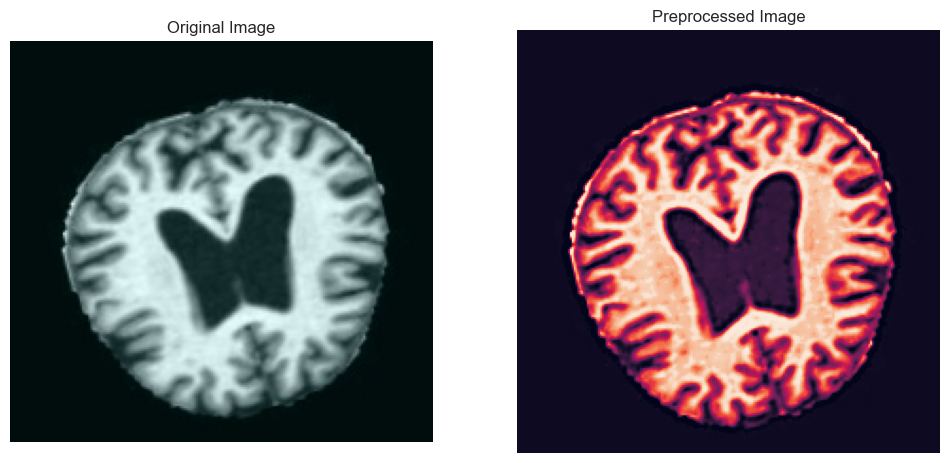

In [80]:
# Sample MRI before and after preprocessing

sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[5])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

In [81]:
# Dataset splitting 

train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [82]:
# custom model inspired by the AlexNet architecture 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        return self.leakyrelu(self.bn(self.conv(x)))
    
class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv3 = nn.Conv2d(inter_channels, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.leakyrelu(self.bn1(self.conv1(x)))
        x = self.leakyrelu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        return self.leakyrelu(x)
    
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(1, 64, kernel_size=11, stride=4, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConvBlock(64, 192, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Bottleneck(192, 256, 384),
            ConvBlock(384, 256, kernel_size=3, stride=1, padding=1),
            ConvBlock(256, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        output_size = 256 * 6 * 6 

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_size, 4096),
            nn.LeakyReLU(0.01),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.01),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x


# create an instance of the custom AlexNet model
model1 = CustomAlexNet(num_classes=4)

In [83]:
summary(model1, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]           7,808
       BatchNorm2d-2           [-1, 64, 55, 55]             128
         LeakyReLU-3           [-1, 64, 55, 55]               0
         ConvBlock-4           [-1, 64, 55, 55]               0
         MaxPool2d-5           [-1, 64, 27, 27]               0
            Conv2d-6          [-1, 192, 27, 27]         307,392
       BatchNorm2d-7          [-1, 192, 27, 27]             384
         LeakyReLU-8          [-1, 192, 27, 27]               0
         ConvBlock-9          [-1, 192, 27, 27]               0
        MaxPool2d-10          [-1, 192, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]          74,112
      BatchNorm2d-12          [-1, 384, 13, 13]             768
           Conv2d-13          [-1, 256, 13, 13]          49,408
      BatchNorm2d-14          [-1, 256,

In [84]:
print(model1)

CustomAlexNet(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Bottleneck(
      (conv1): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Epoch 1 [train] Progress: 100%|██████████| 1487/1487 [11:37<00:00,  2.13batch/s]


train Loss: 1.0952 Acc: 0.5300


Epoch 1 [val] Progress: 100%|██████████| 319/319 [00:56<00:00,  5.65batch/s]


val Loss: 0.7771 Acc: 0.6055


Epoch 2 [train] Progress: 100%|██████████| 1487/1487 [11:55<00:00,  2.08batch/s]


train Loss: 0.7393 Acc: 0.6587


Epoch 2 [val] Progress: 100%|██████████| 319/319 [00:58<00:00,  5.49batch/s]


val Loss: 0.6626 Acc: 0.6796


Epoch 3 [train] Progress: 100%|██████████| 1487/1487 [12:16<00:00,  2.02batch/s]


train Loss: 0.6092 Acc: 0.7257


Epoch 3 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.40batch/s]


val Loss: 0.8949 Acc: 0.6800


Epoch 4 [train] Progress: 100%|██████████| 1487/1487 [12:21<00:00,  2.00batch/s]


train Loss: 0.5039 Acc: 0.7783


Epoch 4 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.35batch/s]


val Loss: 0.4598 Acc: 0.8001


Epoch 5 [train] Progress: 100%|██████████| 1487/1487 [12:25<00:00,  2.00batch/s]


train Loss: 0.4593 Acc: 0.8095


Epoch 5 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.32batch/s]


val Loss: 0.8197 Acc: 0.7820


Epoch 6 [train] Progress: 100%|██████████| 1487/1487 [12:28<00:00,  1.99batch/s]


train Loss: 0.4091 Acc: 0.8364


Epoch 6 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.33batch/s]


val Loss: 0.3652 Acc: 0.8481


Epoch 7 [train] Progress: 100%|██████████| 1487/1487 [12:29<00:00,  1.98batch/s]


train Loss: 0.3620 Acc: 0.8585


Epoch 7 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.33batch/s]


val Loss: 0.4659 Acc: 0.8525


Epoch 8 [train] Progress: 100%|██████████| 1487/1487 [12:29<00:00,  1.99batch/s]


train Loss: 0.3140 Acc: 0.8823


Epoch 8 [val] Progress: 100%|██████████| 319/319 [01:00<00:00,  5.31batch/s]


val Loss: 1.8384 Acc: 0.6657


Epoch 9 [train] Progress: 100%|██████████| 1487/1487 [12:32<00:00,  1.98batch/s]


train Loss: 0.2448 Acc: 0.9112


Epoch 9 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.32batch/s]


val Loss: 0.5078 Acc: 0.8277


Epoch 10 [train] Progress: 100%|██████████| 1487/1487 [12:29<00:00,  1.98batch/s]


train Loss: 0.2229 Acc: 0.9232


Epoch 10 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.34batch/s]


val Loss: 0.2745 Acc: 0.8950


Epoch 11 [train] Progress: 100%|██████████| 1487/1487 [12:33<00:00,  1.97batch/s]


train Loss: 0.2171 Acc: 0.9245


Epoch 11 [val] Progress: 100%|██████████| 319/319 [01:00<00:00,  5.27batch/s]


val Loss: 0.3133 Acc: 0.8876


Epoch 12 [train] Progress: 100%|██████████| 1487/1487 [12:35<00:00,  1.97batch/s]


train Loss: 0.1516 Acc: 0.9477


Epoch 12 [val] Progress: 100%|██████████| 319/319 [00:58<00:00,  5.44batch/s]


val Loss: 0.3627 Acc: 0.8923


Epoch 13 [train] Progress: 100%|██████████| 1487/1487 [12:20<00:00,  2.01batch/s]


train Loss: 0.1529 Acc: 0.9496


Epoch 13 [val] Progress: 100%|██████████| 319/319 [00:59<00:00,  5.34batch/s]


val Loss: 0.3090 Acc: 0.8893


Epoch 14 [train] Progress: 100%|██████████| 1487/1487 [12:16<00:00,  2.02batch/s]


train Loss: 0.1266 Acc: 0.9583


Epoch 14 [val] Progress: 100%|██████████| 319/319 [00:58<00:00,  5.44batch/s]


val Loss: 0.3051 Acc: 0.8892


Epoch 15 [train] Progress: 100%|██████████| 1487/1487 [12:20<00:00,  2.01batch/s]


train Loss: 0.1199 Acc: 0.9615


Epoch 15 [val] Progress: 100%|██████████| 319/319 [00:58<00:00,  5.42batch/s]


val Loss: 0.6797 Acc: 0.8299
Early stopping at epoch 15


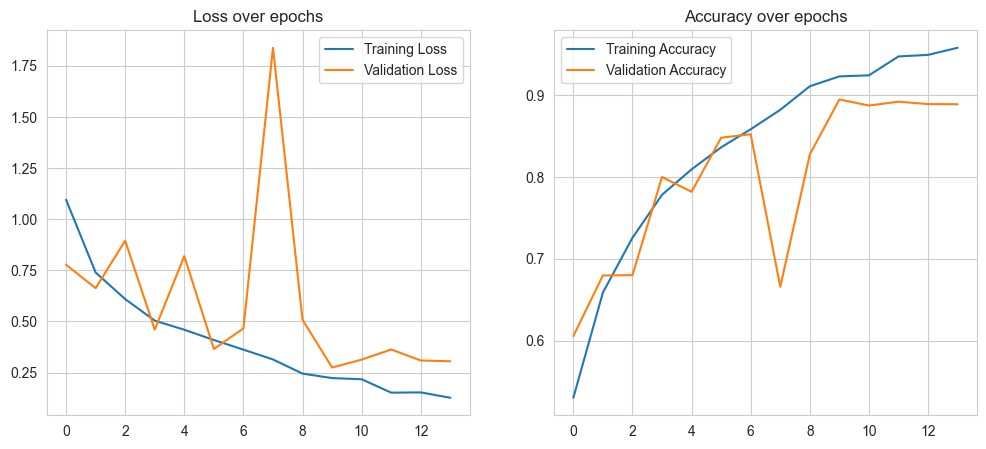

In [85]:
# code to train and evaluate the Custom AlexNet model from scratch (without the pre-trained weights)

model1 = CustomAlexNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


def train_epoch(epoch_index, train_loader, model, optimizer):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model1.train()  # Set model to training mode
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model1.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model1, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model1)

    # Learning rate scheduling step
    scheduler.step(val_loss)  # Adjusted for ReduceLROnPlateau

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model1.state_dict(), 'AlexNet_38_x1.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Store losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [86]:
torch.save(model1.state_dict(), 'AlexNet_38_x1.pth') # saving the trained model

In [87]:
# classification report (val loader)
loaded_model = CustomAlexNet(num_classes=4).to(device)

loaded_model.load_state_dict(torch.load('AlexNet_38_x1.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.93      0.88      0.90      1373
ModerateDemented       1.00      0.71      0.83       976
     NonDemented       0.94      0.77      0.85      1397
VeryMildDemented       0.64      0.93      0.76      1351

        accuracy                           0.83      5097
       macro avg       0.88      0.82      0.83      5097
    weighted avg       0.87      0.83      0.83      5097


In [88]:
# classification report (test loader)

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.93      0.87      0.90      1357
ModerateDemented       1.00      0.72      0.83       960
     NonDemented       0.94      0.78      0.85      1410
VeryMildDemented       0.65      0.94      0.77      1372

        accuracy                           0.83      5099
       macro avg       0.88      0.82      0.84      5099
    weighted avg       0.87      0.83      0.84      5099


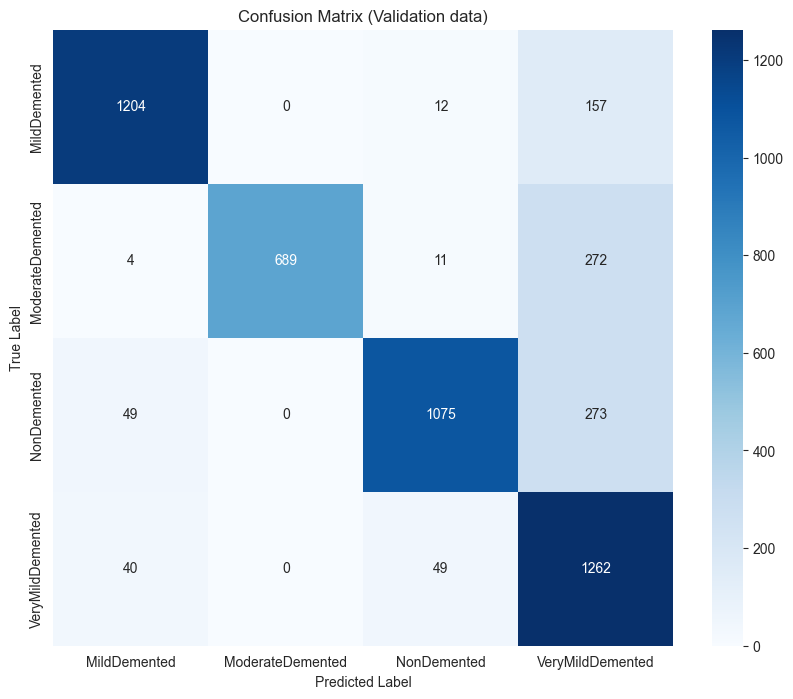

In [89]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, val_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

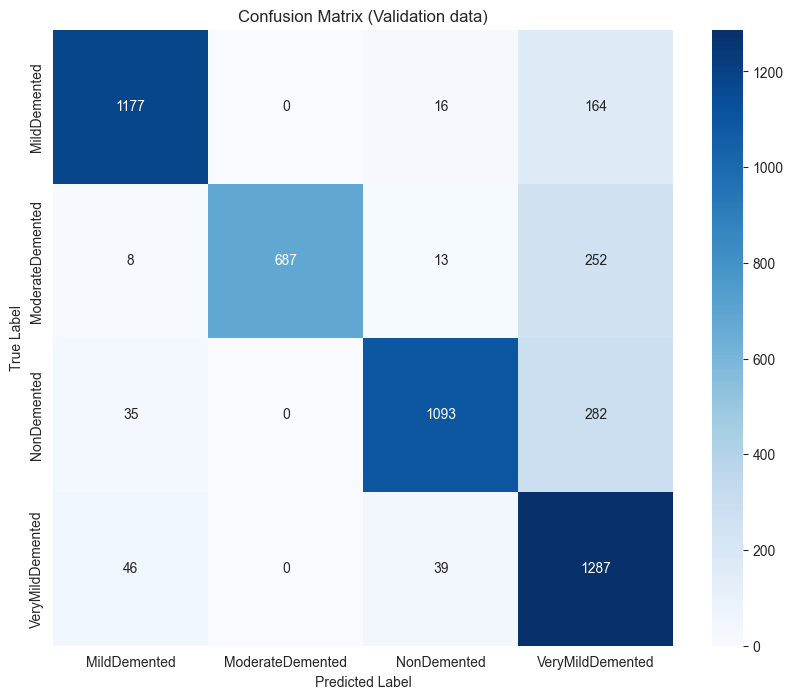

In [90]:
# Confusion Matrix on test loader (unseen data)

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
# Confusion Matrix on test dataset (unseen data)

test_data_dir = '/Users/savin/Desktop/FYP/Implementation/AD_Dataset/test'

preprocessed_test_dataset = datasets.ImageFolder(root=test_data_dir, transform=preprocess_transform)

test_dataset_loader = DataLoader(preprocessed_test_dataset, batch_size=32, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, test_dataset_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/savin/Desktop/FYP/Implementation/AD_Dataset/test'

In [91]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, loaded_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-01-29 10:34:06.058 Python[5414:213151] +[CATransaction synchronize] called within transaction


Predicted class: Mild Demented
/Users/tharanidissanayake/Downloads/AugmentedAlzheimerDataset/MildDemented/0a1bcb90-7dba-45a9-a9eb-2c385d111c5a.jpg


In [117]:
# predictions for the uploaded MRI images
# uploaded 10 Very Mild Demented MRI images = 10/10 correct predictions
# uploaded 10 Non Demented MRI images = 8/10 correct predictions
# uploaded 10 Moderate Demented MRI images = 10/10 correct predictions
# uploaded 10 Mild Demented MRI images = 10/10 correct predictions

In [26]:
# Save the best model locally (AlexNet Original Modified 38 layers)

model_save_path = '/Users/tharanidissanayake/Desktop' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'AlexNet_38_x1.pth')

torch.save(loaded_model.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')

Model saved to /Users/tharanidissanayake/Desktop/AlexNet_38_x1.pth


In [92]:
# Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = loaded_model.features[4]  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(loaded_model, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

NameError: name 'GradCAM' is not defined